In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_DNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


<!-- <span style="color:#fff; font-family: 'Bebas Neue'; font-size: 1.2em;">Number of iterations</span> -->

In [2]:
from tensorflow import keras

## Vanishing/Exploding Gradients Problem

As we discussed in Chapter 10, the backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. We call this the **`vanishing gradients`** problem. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the **`exploding gradients`** problem, which surfaces in recurrent neural networks (see Chapter 15). More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

***This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s. It wasn’t clear what caused the gradients to be so unstable when training a DNN, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio.1 The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).***

***Looking at the logistic activation function (see Figure 11-1), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.***

In [3]:
def logit(z):
    return 1/(1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


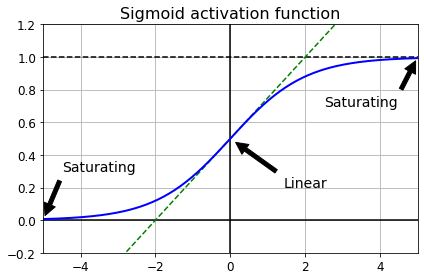

In [85]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), 'b-', linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha='center')
plt.grid(True)
plt.title('Sigmoid activation function', fontsize=16)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Glorot and He Initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction (please check out the paper if you are interested in the mathematical details). It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the fan-in and fan-out of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in Equation 11-1, where $fan_{avg} = (fan_{in} + fan_{out}/2$. This initialization strategy is called ***Xavier initialization or Glorot initialization***, after the paper’s first author.

***Equation 11-1. Glorot initialization (when using the logistic activation function)*** <br>
Normal distribution with mean $0$ and variance $\sigma^2 = \frac{1}{fan_{avg}}$  
Or a uniform distribution between $-r$ and $+r$, with $r = \sqrt{\frac{3}{fan_{avg}}}$

If you replace $fan_{avg}$ with $fan_{in}$ in Equation 11-1, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it *LeCun initialization*. Genevieve Orr and Klaus-Robert Müller even recommended it in their 1998 book *Neural Networks*: *Tricks of the Trade* (Springer). LeCun initialization is equivalent to Glorot initialization when $fan_{in} = fan_{out}$. It took over a decade for researchers to realize how important this trick is. Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning.

Some papers have provided similar strategies for different activation functions. These strategies differ only by the scale of the variance and whether they use $fan_{avg}$ or $fan_{in}$, as shown in Table 11-1 (for the uniform distribution, just compute $r = \sqrt{3\sigma^2}$). The initialization strategy for the ReLU activation function (and its variants, including the ELU activation described shortly) is sometimes called `He initialization`, after the paper’s first author. The SELU activation function will be explained later in this chapter. It should be used with LeCun initialization (preferably with a normal distribution, as we will see).

![Initialization parameters of each type of activation function](images/training_DNN/initialization_parameters_activation_func.png)

In [65]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

By default, Keras uses ***Glorot*** initialization with a uniform distribution. When creating a layer, you can change this to ***He*** initialization by setting ***kernel_initializer='he_uniform'*** or ***kernel_initializer='he_normal'*** like this:
``` python
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')
```

If you want ***He*** initialization with a uniform distribution but based on ***fan***$_{avg}$ rather than ***fan***$_{in}$, you can use the ***VarianceScaling*** initializer like this:
``` python
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)
```

In [66]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [67]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function. Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. But it turns out that other activation functions behave much better in deep neural networks—in particular, ***`the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute)`***

**Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, some neurons effectively “die,” meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.**

***To solve this problem, you may want to use a variant of the ReLU function, such as the `leaky ReLU`. This function is defined as $LeakyReLU_α(z) = max(αz, z)$ (see Figure 11-2). The hyperparameter $α$ defines how much the function `“leaks”`: it is the slope of the function for $z < 0$ and is typically set to $0.01$. `This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up.` A [2015 paper](https://homl.info/49) `compared several variants of the ReLU activation function, and one of its conclusions was that the leaky variants always outperformed the strict ReLU activation function.` In fact, setting $α = 0.2$ (a huge leak) seemed to result in better performance than $α = 0.01$ (a small leak). The paper also evaluated the `randomized leaky ReLU (RReLU)`, where $α$ is picked randomly in a given range during training and is fixed to an average value during testing. `RReLU also performed fairly well and seemed to act as a regularizer (reducing the risk of overfitting the training set).` Finally, the paper evaluated the `parametric leaky ReLU (PReLU)`, where $α$ is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). `PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.`***

In [86]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [91]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

### ReLU

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [103]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 4ms/step - loss: 1.8506 - accuracy: 0.4323 - val_loss: 1.0055 - val_accuracy: 0.7110
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9354 - accuracy: 0.7177 - val_loss: 0.7534 - val_accuracy: 0.7652
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7437 - accuracy: 0.7588 - val_loss: 0.6670 - val_accuracy: 0.7880
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6584 - accuracy: 0.7847 - val_loss: 0.6064 - val_accuracy: 0.8044
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6166 - accuracy: 0.7983 - val_loss: 0.5686 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5751 - accuracy: 0.8113 - val_loss: 0.5419 - val_accuracy: 0.8258
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5471 - accuracy: 0.8201 - val_loss: 0.5200 - val_accuracy

In [101]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal', activation='relu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 3ms/step - loss: 1.6975 - accuracy: 0.4971 - val_loss: 0.9259 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8709 - accuracy: 0.7245 - val_loss: 0.7308 - val_accuracy: 0.7626
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7213 - accuracy: 0.7620 - val_loss: 0.6566 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6449 - accuracy: 0.7881 - val_loss: 0.6005 - val_accuracy: 0.8044
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6078 - accuracy: 0.8003 - val_loss: 0.5657 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5693 - accuracy: 0.8119 - val_loss: 0.5407 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5428 - accuracy: 0.8195 - val_loss: 0.5197 - val_accuracy

In [104]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_16 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Leaky ReLU

In [68]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


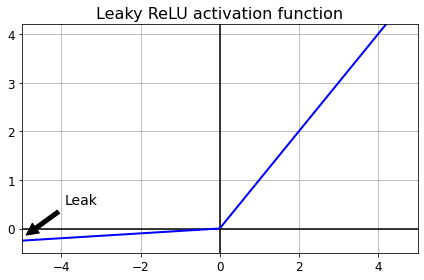

In [84]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.plot(z, leaky_relu(z, 0.05), 'b-', linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha='center')
plt.grid(True)
plt.title('Leaky ReLU activation function', fontsize=16)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

To use the leaky ReLU activation function, create a ***`LeakyReLU`*** layer and add it to your model just after the layer you want to apply it to:

```python
model = keras.models.Sequential([
    [...]
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
    [...]
])
```

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [93]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [94]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
________________________________________________

In [95]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [96]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 1.6314 - accuracy: 0.5054 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8416 - accuracy: 0.7246 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7053 - accuracy: 0.7637 - val_loss: 0.6427 - val_accuracy: 0.7902
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6325 - accuracy: 0.7907 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5992 - accuracy: 0.8019 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5624 - accuracy: 0.8142 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5379 - accuracy: 0.8218 - val_loss: 0.5157 - val_accuracy:

### Now let's try PReLU:

For ***PReLU***, replace ***LeakyRelu(alpha=0.2)*** with ***`PReLU()`***. There is currently no official implementation of RReLU in Keras, but you can fairly easily implement your own (to learn how to do that, see the exercises at the end of Chapter 12).

In [97]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [98]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
p_re_lu (PReLU)              (None, 300)               300       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 100)               100       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 267,010
Trainable params: 267,010
Non-trainable params: 0
________________________________________________

In [99]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [100]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.6969 - accuracy: 0.4974 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8706 - accuracy: 0.7247 - val_loss: 0.7305 - val_accuracy: 0.7632
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7211 - accuracy: 0.7620 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6448 - accuracy: 0.7880 - val_loss: 0.6003 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6078 - accuracy: 0.8003 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5693 - accuracy: 0.8117 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5428 - accuracy: 0.8193 - val_loss: 0.5196 - val_accuracy:

### ELU

Last but not least, a [2015 paper](https://homl.info/50) by Djork-Arné Clevert et al. proposed a new activation function called the **`exponential linear unit (ELU)`** that outperformed all the ReLU variants in the authors’ experiments: `training time was reduced, and the neural network performed better on the test set.` Figure 11-3(below) graphs the function, and Equation 11-2 shows its definition.

*Equation 11-2. ELU activation function*

**ELU**$_\alpha (z) = \alpha(exp(z)-1$ **`if`** $z < 0$, $z$ **`if`** $z>= 0$

In [37]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure ELU_plot


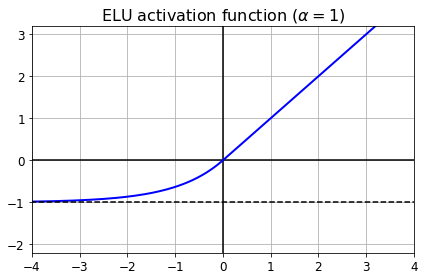

In [38]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.plot(z, elu(z), 'b-', linewidth=2)
plt.plot([-5, 5], [-1, -1], 'k--')

plt.grid(True)
plt.title(r'ELU activation function ($\alpha=1$)', fontsize=16)
plt.axis([-4, 4, -2.2, 3.2])

save_fig("ELU_plot")
plt.show()

The ELU activation function looks a lot like the ReLU function, with a few major differences:
* It takes on negative values when $z < 0$, which allows the unit to have an average output closer to $0$ and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.

* It has a nonzero gradient for $z < 0$, which avoids the dead neurons problem.

* If $\alpha$ is equal to $1$ then the function is smooth everywhere, including around $z = 0$, which helps speed up Gradient Descent since it does not bounce as much to the left and right of $z = 0$.

`The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.`

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [26]:
keras.layers.Dense(10, activation="elu")

### SELU

Then, a [2017 paper](https://homl.info/selu) by Günter Klambauer et al. introduced the `Scaled ELU (SELU)` activation function: as its name suggests, it is a scaled variant of the ELU activation function. The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to `preserve a mean of 0 and standard deviation of 1 during training`, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones). There are, however, a few conditions for self-normalization to happen (see the paper for the mathematical justification):

* The input features must be standardized (mean 0 and standard deviation 1).

* Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting `kernel_initializer="lecun_normal"`.

* `The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks (see Chapter 15) or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.`

* `The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well (see Chapter 14).`

For ***SELU*** activation, set ***`activation="selu"`*** and ***`kernel_initializer="lecun_normal"`*** when creating a layer:

```python
keras.layers.Dense(10, activation='selu', 
                  kernel_initializer='lecun_normal')
```

In [27]:
keras.layers.Dense(10, activation='selu', 
                  kernel_initializer='lecun_normal')

> ***`In Colab notebook`***

> This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, `this activation function outperforms the other activation functions very significantly for such neural nets`, so you should really try it out. `Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use` ℓ<sub>1</sub> `or` ℓ<sub>2</sub> `regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize).` ***However, in practice it works quite well with sequential CNNs.*** `If you break self-normalization, SELU will not necessarily outperform other activation functions.`

In [29]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [30]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


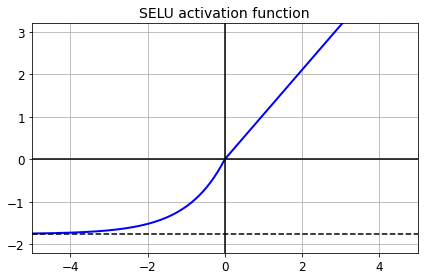

In [39]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the ***SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:***

In [40]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [41]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

***Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:***

In [45]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [46]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 35s 18ms/step - loss: 1.5515 - accuracy: 0.4109 - val_loss: 1.0267 - val_accuracy: 0.6228
Epoch 2/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.8707 - accuracy: 0.6588 - val_loss: 0.7100 - val_accuracy: 0.7198
Epoch 3/5
1719/1719 [==============================] - 30s 18ms/step - loss: 0.7340 - accuracy: 0.7023 - val_loss: 0.6401 - val_accuracy: 0.7432
Epoch 4/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.6358 - accuracy: 0.7548 - val_loss: 0.5612 - val_accuracy: 0.8010
Epoch 5/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.5677 - accuracy: 0.7932 - val_loss: 0.5534 - val_accuracy: 0.8102


***Now look at what happens if we try to use the ReLU activation function instead:***

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu",
                             kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu",
                                 kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [48]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [49]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 16ms/step - loss: 2.0794 - accuracy: 0.1857 - val_loss: 1.2931 - val_accuracy: 0.4426
Epoch 2/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.2462 - accuracy: 0.4646 - val_loss: 0.8471 - val_accuracy: 0.6764
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.1994 - accuracy: 0.5252 - val_loss: 0.8759 - val_accuracy: 0.6806
Epoch 4/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.9132 - accuracy: 0.6373 - val_loss: 0.7527 - val_accuracy: 0.7110
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.7970 - accuracy: 0.6848 - val_loss: 0.7049 - val_accuracy: 0.7310


***`Not great at all, we suffered from the vanishing/exploding gradients problem.`***

## TIP

> So, which activation function should you use for the hidden layers of your deep neural networks? Although your mileage will vary, in general **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic</span>**. If the network’s architecture prevents it from self-normalizing, then **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">ELU</span>** may perform better than **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">SELU</span>** (since **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">SELU</span>** is not smooth at $z = 0$). If you care a lot about runtime latency, then you may prefer **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">leaky ReLU</span>**. If you don’t want to tweak yet another hyperparameter, you may use the default $α$ values used by Keras (e.g., $0.3$ for **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">leaky ReLU</span>**). If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, such as **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">RReLU</span>** if your network is overfitting or **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">PReLU</span>** if you have a huge training set. That said, because **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">ReLU</span>** is the most used activation function (by far), many libraries and hardware accelerators provide **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">ReLU</span>**-specific optimizations; therefore, if speed is your priority, **<span style= "font-family: 'Bebas Neue'; font-size:1.2em">ReLU</span>** might still be the best choice.

### Batch Normalization

Although using _He_ initialization along with *ELU* (or any variant of *ReLU*) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.

In a [2015 paper](https://homl.info/51), Sergey Ioffe and Christian Szegedy proposed a technique called `Batch Normalization (BN) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).`

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”). The whole operation is summarized step by step in Equation 11-3.

![Batch Normalization algorithm](images/training_DNN/batch_normalization_algo.png)

In this algorithm:

* $μ_B$ is the vector of input means, evaluated over the whole mini-batch $B$ (it contains one mean per input).

* $σ_B$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).

* $m_B$ is the number of instances in the mini-batch.

* $\hat{x}^{(i)}$ is the vector of zero-centered and normalized inputs for instance $i$.

* $γ$ is the output scale parameter vector for the layer (it contains one scale parameter per input).

* $⊗$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).

* $β$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.

* $ε$ is a tiny number that avoids division by zero (typically $10^{–5}$). This is called a `smoothing` term.

* $z^{(i)}$ is the output of the BN operation. It is a rescaled and shifted version of the inputs.

So during training, BN standardizes its inputs, then rescales and offsets them. Good! What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable. `One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. However, most implementations of Batch Normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations.` This is what Keras does automatically when you use the BatchNormalization layer. To sum up, four parameter vectors are learned in each batch-normalized layer: $\gamma$ (the output scale vector) and $\beta$ (the output offset vector) are learned through regular backpropagation, and μ (the final input mean vector) and $\sigma$ (the final input standard deviation vector) are estimated using an exponential moving average. Note that $\mu$ and $\sigma$ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in Equation 11-3).

Ioffe and Szegedy demonstrated that Batch Normalization considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes, commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the logistic activation function. The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process. Specifically, they note that:

> ***Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. […] Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.***

`Finally, like a gift that keeps on giving, Batch Normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout, described later in this chapter).`

Batch Normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. Fortunately, it’s often possible to fuse the BN layer with the previous layer, after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset. For example, if the previous layer computes $XW + b$, then the BN layer will compute $γ⊗(XW + b – μ)/σ + β$ (ignoring the smoothing term $ε$ in the denominator). If we define $W′ = γ⊗W/σ$ and $b′ = γ⊗(b – μ)/σ + β$, the equation simplifies to $XW′ + b′$. So if we replace the previous layer’s weights and biases ($W$ and $b$) with the updated weights and biases ($W′$ and $b′$), we can get rid of the BN layer (TFLite’s optimizer does this automatically; see Chapter 19).

### NOTE

> You may find that training is rather slow, because each epoch takes much more time when you use Batch Normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance. All in all, `wall time` will usually be shorter (this is the time measured by the clock on your wall).

### Implementing Batch Normalization with Keras

As with most things with Keras, implementing Batch Normalization is simple and intuitive. Just add a BatchNormalization layer before or after each hidden layer’s activation function, and optionally add a BN layer as well as the first layer in your model. For example, this model applies BN after every hidden layer and as the first layer in the model (after flattening the input images):

In [56]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
#     keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.BatchNormalization(),
#     keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

That’s all! **`In this tiny example with just two hidden layers, it’s unlikely that Batch Normalization will have a very positive impact; but for deeper networks it can make a tremendous difference.`**

Let’s display the model summary:

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_208 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
dense_209 (Dense)            (None, 300)               90300     
_________________________________________________________________
batch_normalization_5 (Batch (None, 300)               1200      
_________________________________________________________________
dense_210 (Dense)            (None, 10)               

As you can see, each BN layer adds four parameters per input: $γ$, $β$, $μ$, and $σ$ (for example, the first BN layer adds $3,136$ parameters, which is $4 × 784$). The last two parameters, $μ$ and $σ$, are the moving averages; they are not affected by backpropagation, so Keras calls them “non-trainable” (if you count the total number of BN parameters, $3,136 + 1,200 + 400$, and divide by $2$, you get $2,368$, which is the total number of non-trainable parameters in this model).

Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:

In [58]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

Now when you create a BN layer in Keras, it also creates **`two operations` that will be called by Keras at each iteration during training. These operations will update the moving averages.** Since we are using the TensorFlow backend, these operations are TensorFlow operations (we will discuss TF operations in Chapter 12):

In [59]:
# bn1.updates #deprecated

In [63]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [61]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 6ms/step - loss: 1.0867 - accuracy: 0.6377 - val_loss: 0.5053 - val_accuracy: 0.8268
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5625 - accuracy: 0.8011 - val_loss: 0.4401 - val_accuracy: 0.8492
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5007 - accuracy: 0.8237 - val_loss: 0.4117 - val_accuracy: 0.8588
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4586 - accuracy: 0.8373 - val_loss: 0.3937 - val_accuracy: 0.8612
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4427 - accuracy: 0.8436 - val_loss: 0.3822 - val_accuracy: 0.8648
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4132 - accuracy: 0.8521 - val_loss: 0.3730 - val_accuracy: 0.8704
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4003 - accuracy: 0.8578 - val_loss: 0.3646 - val_ac

In [77]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
keras.layers.BatchNormalization(),
model.add(keras.layers.Dense(300, activation="relu", 
                             kernel_initializer='he_normal'))
keras.layers.BatchNormalization(), # commented when testing on without BN layer

for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", 
                                kernel_initializer='he_normal'))
    keras.layers.BatchNormalization(), # commented when testing on without BN layer
model.add(keras.layers.Dense(10, activation="softmax"))

In [78]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [69]:
# with batch normalization layer + when kernel_initializer not given
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 30s 16ms/step - loss: 2.3026 - accuracy: 0.1004 - val_loss: 2.3026 - val_accuracy: 0.0914
Epoch 2/5
1719/1719 [==============================] - 28s 16ms/step - loss: 2.3026 - accuracy: 0.0992 - val_loss: 2.3027 - val_accuracy: 0.0914
Epoch 3/5
1719/1719 [==============================] - 28s 16ms/step - loss: 2.3026 - accuracy: 0.0985 - val_loss: 2.3027 - val_accuracy: 0.0914
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: 2.3026 - accuracy: 0.1030 - val_loss: 2.3027 - val_accuracy: 0.0914
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 2.3026 - accuracy: 0.1008 - val_loss: 2.3027 - val_accuracy: 0.0914


In [79]:
# with batch normalization layer with kernel_initializer='he_normal'
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 17ms/step - loss: 2.0873 - accuracy: 0.2029 - val_loss: 1.7030 - val_accuracy: 0.3480
Epoch 2/5
1719/1719 [==============================] - 31s 18ms/step - loss: 1.7249 - accuracy: 0.3299 - val_loss: 1.3305 - val_accuracy: 0.4888
Epoch 3/5
1719/1719 [==============================] - 27s 15ms/step - loss: 1.3244 - accuracy: 0.4778 - val_loss: 1.3690 - val_accuracy: 0.4374
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.0806 - accuracy: 0.5655 - val_loss: 0.8215 - val_accuracy: 0.6950
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.0400 - accuracy: 0.5943 - val_loss: 1.2865 - val_accuracy: 0.4812


In [76]:
# without batch normalization layer expect after input layer  with kernel_initializer='he_normal'
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 31s 16ms/step - loss: 2.0873 - accuracy: 0.2029 - val_loss: 1.7030 - val_accuracy: 0.3480
Epoch 2/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.7249 - accuracy: 0.3299 - val_loss: 1.3305 - val_accuracy: 0.4888
Epoch 3/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.3244 - accuracy: 0.4778 - val_loss: 1.3690 - val_accuracy: 0.4374
Epoch 4/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.0806 - accuracy: 0.5655 - val_loss: 0.8215 - val_accuracy: 0.6950
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.0400 - accuracy: 0.5943 - val_loss: 1.2865 - val_accuracy: 0.4812


`The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did). There is some debate about this, as which is preferable seems to depend on the task—you can experiment with this too to see which option works best on your dataset. To add the BN layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the BN layers. Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass use_bias=False when creating it):`